In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil
import cv2
import numpy as np
import scipy



os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])

train_dir = '/home/joe/Desktop/must_graduation/deep-learningntut-classroom-2019-autumn/train'
validation_dir = '/home/joe/Desktop/must_graduation/deep-learningntut-classroom-2019-autumn/validation'
test_dir = '/home/joe/Desktop/must_graduation/deep-learningntut-classroom-2019-autumn/test'

In [10]:
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

True

In [23]:
# directory_list = list()
# for root, dirs, files in os.walk(train_dir, topdown=False):
#     for name in dirs:
#         directory_list.append(name)
#         print(name)
        
# directory_list = list()
# for root, dirs, files in os.walk(train_dir, topdown=False):
#     for name in dirs:
#         directory_list.append(name)

# # Create validation folder
# for folderName in directory_list:
# 	validation_dir_name = os.path.join(validation_dir, folderName)
# 	if not os.path.isdir(validation_dir_name):
# 		os.mkdir(validation_dir_name) 
	
# for folderName in directory_list:
# 	root, dirs, files = next(os.walk(train_dir+'/{}'.format(folderName)))
# 	fileCount = len(files)
# 	for i in range(round(fileCount*0.2)):
# 		valicationDir = folderName+'/{}'.format(files[i])
# 		src = os.path.join(train_dir, valicationDir)
# 		dst = os.path.join(validation_dir, valicationDir)
# 		shutil.copyfile(src, dst)
# 		os.remove(src)
		
# for folderName in directory_list:
# 	root, dirs, files = next(os.walk(validation_dir+'/{}'.format(folderName)))
# 	fileCount = len(files)
# 	print(fileCount)

In [2]:
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}

def load_train_set(dirname,dict_characters):
    X_train = []
    Y_train = []
    for label,character in dict_characters.items():
        list_images = os.listdir(dirname+'/'+character)
        for image_name in list_images:
            image = cv2.imread(dirname+'/'+character+'/'+image_name)
            X_train.append(cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC))
            Y_train.append(label)
    return np.array(X_train), np.array(Y_train)

def load_validation_set(dirname,dict_characters):
    X_val = []
    Y_val = []
    for label,character in dict_characters.items():
        list_images = os.listdir(dirname+'/'+character)
        for image_name in list_images:
            image = cv2.imread(dirname+'/'+character+'/'+image_name)
            X_val.append(cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC))
            Y_val.append(label)
    return np.array(X_val), np.array(Y_val)

def load_test_set(dirname):
    X_test = []
    file = os.listdir(dirname)
    file.sort(key=lambda x:int(x[:-4]))
    for image_name in file:
        image = cv2.imread(test_dir+'/'+image_name)
        X_test.append(cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC))
    return np.array(X_test)

X_train, Y_train = load_train_set(train_dir, dict_characters)   
X_val, Y_val = load_validation_set(validation_dir, dict_characters) 
X_test = load_test_set(test_dir) 


In [3]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [7]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(15638, 64, 64, 3)
(990, 64, 64, 3)
(3910, 64, 64, 3)


In [5]:
def pick_up_random_element(elem_type,array):
    """This function randomly picks up one element per type in the array"""
    return int(random.choice(np.argwhere(array == elem_type)))

In [6]:
def display_samples(samples_index,imgs,obs, preds_classes=None,preds=None):
    """This function randomly displays 20 images with their observed labels 
    and their predicted ones(if preds_classes and preds are provided)"""
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_index[n]
            ax[row,col].imshow(imgs[index])
            
            actual_label = dict_characters[obs[index]].split("_")[0]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("fantasy")
            
            ax[row,col].text(1, 54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            
            if preds_classes != None and preds != None:
                predicted_label = dict_characters[preds_classes[index]].split('_')[0]
                predicted_proba = max(preds[index])*100
                predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
                ax[row,col].text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            n += 1

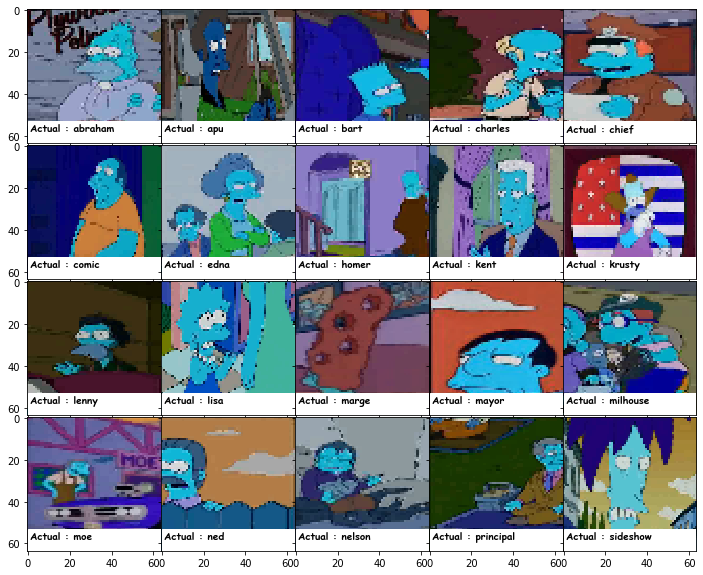

In [7]:
import random
np.random.seed(2)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
samples = [pick_up_random_element(elem_type,Y_train) for elem_type in range(20)]

display_samples(samples,X_train,Y_train)

In [4]:
Y_train = to_categorical(Y_train, num_classes = 20)
Y_val = to_categorical(Y_val, num_classes = 20)

In [5]:
train_datagen = ImageDataGenerator(
	rotation_range=40,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	zoom_range=0.2,
	horizontal_flip=True,
	fill_mode='nearest'
  )

train_datagen.fit(X_train)

In [6]:
conv_base = VGG16(weights='imagenet',  
                  include_top=False,
                 input_shape=(64 ,64, 3))
# conv_base.summary()
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop


model = models.Sequential()
model.add(conv_base)       
model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(20, activation='softmax'))
model.summary() 




# model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu', input_shape = (64,64,3)))
# model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Flatten())
# #model.add(Dense(1024, activation = "relu"))
# #model.add(Dropout(0.5))
# model.add(Dense(512, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(20, activation = "softmax"))
# model.summary()

model.compile( loss='categorical_crossentropy',
			 optimizer=optimizers.RMSprop(lr=0.00001),
			 metrics=['acc'])

epochs = 10
batch_size = 64

history = model.fit_generator(
    train_datagen.flow(X_train,Y_train, batch_size=batch_size, shuffle=True),
	steps_per_epoch=256,
	epochs=epochs,
	validation_data=(X_val, Y_val)
	)


# conv_base.trainable = True
# set_trainable = False

# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False


# model.compile( loss='categorical_crossentropy',
# 			 optimizer=optimizers.RMSprop(lr=1e-5),
# 			 metrics=['acc'])

# history = model.fit_generator(   
#     train_generator,
#     steps_per_epoch=100,
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=50)





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 15,244,372
Trainable params: 7,609,108
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/10
256/256 [==============================] - 25s 99ms/step - loss: 2.6061 - acc: 0.2158 - val_loss: 2.1272 - val_acc: 0.3813
Epoch 2/10
256/256 [==============================] - 23s 90ms/step - loss: 2.0339 - acc: 0.4089 - va

KeyboardInterrupt: 

In [6]:
model.save('simpson_VGG.h5')

NameError: name 'model' is not defined

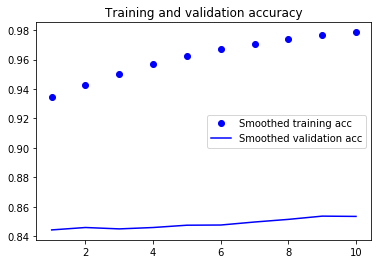

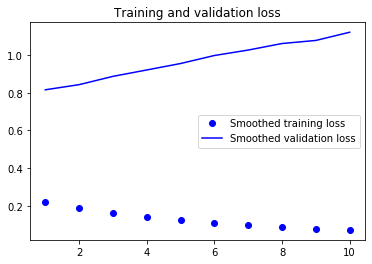

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous * factor + point * (1 - factor))
		else:
			smoothed_points.append(point)
	return smoothed_points

plt.plot( epochs,
	   smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot( epochs,
	   smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot( epochs,
	   smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot( epochs,
	   smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [7]:
from tensorflow.keras.models import load_model
model = load_model('simpson.h5')

In [11]:
loss, acc = model.evaluate(X_val, Y_val, verbose = 0)
print(acc)

0.9455243


In [5]:
result = model.predict(X_test)
result_classes = np.argmax(result, axis = 1)
result_classes[0:5]


array([17,  8, 16, 16,  9], dtype=int64)

In [6]:
result_name = []
for name in result_classes:
    result_name.append(dict_characters[name])

submission = pd.DataFrame({"id":list(range(1, len(result_name)+1)),
                         "character":result_name})

submission.to_csv("simpson_2.csv", index=False, header = True)
